# IMDB Review Sentiment Analysis


- Student name: Johnny Dryman
- Student pace: full time
- Scheduled project review date/time: 5/27/2021
- Instructor name: James Irving

## Business Problem

IMDB is the world's most popular and authoritative source for movie, TV and celebrity content, designed to help fans explore the world of movies and shows and decide what to watch.

One of the most popular features on the site is its user reviews.  Users are able to give each movie a score between 1-10 along with a written review.  The average score is a recognized metric in the industry, and IMDB's top movies based on user reviews is a coveted list for impactful films.

One of the issues inherent with user submitted scores is that the 1-10 rating system might mean different things to different reviewers.  For example, one reviewer think that a 'good' movie deserves a 6/10, and another might think a 'good' movie deserves an 8/10.  Every user has their own evaluation metrics, and this is often determined internally rather than by a specific standard.

## Natural Language Processing

Using Natural Language Processing (NLP), we can create machine learning models that might help us get closer at the core truth of what people are saying with their written reviews.  

Although not as verbose as a scale form 1-10, we found a dataset where 50,000 IMDB reviews were denoted as 'positive' or 'negative.'  Using this dataset, we can train a model to classify reviews as positive or negative.  In theory, distilling the reviews in this fashion would help us to generate a score based on true sentimentality rather than a sliding scale that has different meanings to different users.

# Packages

We will first want to install the Python packages we will need to perform data import, exploraty data analysis, machine learning modeling, and natural language processing.  

In [1]:
#Standard python libraries
import pandas as pd
import seaborn as sns
# sns.set_context('talk')
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings(action='ignore') 

# Preprocessing tools
from sklearn.model_selection import train_test_split,cross_val_predict,cross_validate
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
scaler = StandardScaler()
from sklearn import metrics

# # Models & Utilities
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Warnings
import warnings
warnings.filterwarnings(action='ignore') 

# NLP Libraries
import nltk
import collections
nltk.download('punkt')
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from nltk import regexp_tokenize
import re
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
from nltk import ngrams
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
# !pip install wordcloud
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Johnny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Johnny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data

The data for this project was sourced from Kaggle, a data science community featuring great datasets for exploration and analysis.  The dataset contained 25,000 positive reviews and 25,000 negative reviews, totaling 50,000.  The only other data provided were 'positive' and 'negative' classifications.  According to the source, the reviews were "highly polar," meaning they were strongly positive or strongly negative.

In [2]:
# Import .csv file obtained from Kaggle
df = pd.read_csv('data/IMDB Dataset.csv')

# View first 5 rows
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# Taking a look at our columns
print(df.info())

# Checking for NA data
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
review       0
sentiment    0
dtype: int64


Fortunately our data has no nulls that we need to worry about.

In [4]:
# View class balance
df['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

The reviews are also very balanced across positive and negative sentiment.

In [5]:
# View pandas 'describe' to check for data issues
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


There are a few hundred duplicates in the data.  Removing them will not violate any data science best practices.

In [6]:
# Drop duplicates from dataframe
df = df.drop_duplicates()

# Text Preprocessing

One of the most crucial aspects of NLP is preparing the data for machine learning models.  To do this, we will need to remove punctuation, symbols, and 'stopwords' - common English language words that while important for communication, are less helpful our models.  

In [7]:
# Taking a glance at the first 500 characters of our first review
first_review = df['review'][0][0:500]
first_review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ"

Let's take a look at how NLTK, a robust Python library for NLP, will 'tokenize' our first review.  Tokenization is the process of splitting our reviews into a list of strings rather than one large string.  

In [8]:
# Designating pattern for regex tokenizer
pattern = r"([a-zA-Z]+(?:'[a-z]+)?)"

# Tokenize our first review based on the pattern
regexp_tokenize(first_review, pattern)

['One',
 'of',
 'the',
 'other',
 'reviewers',
 'has',
 'mentioned',
 'that',
 'after',
 'watching',
 'just',
 'Oz',
 'episode',
 "you'll",
 'be',
 'hooked',
 'They',
 'are',
 'right',
 'as',
 'this',
 'is',
 'exactly',
 'what',
 'happened',
 'with',
 'me',
 'br',
 'br',
 'The',
 'first',
 'thing',
 'that',
 'struck',
 'me',
 'about',
 'Oz',
 'was',
 'its',
 'brutality',
 'and',
 'unflinching',
 'scenes',
 'of',
 'violence',
 'which',
 'set',
 'in',
 'right',
 'from',
 'the',
 'word',
 'GO',
 'Trust',
 'me',
 'this',
 'is',
 'not',
 'a',
 'show',
 'for',
 'the',
 'faint',
 'hearted',
 'or',
 'timid',
 'This',
 'show',
 'pulls',
 'no',
 'punches',
 'with',
 'regards',
 'to',
 'drugs',
 'sex',
 'or',
 'violence',
 'Its',
 'is',
 'hardcore',
 'in',
 'the',
 'classic',
 'use',
 'of',
 'the',
 'word',
 'br',
 'br',
 'It',
 'is',
 'called',
 'OZ']

## Tokenizer

By creating a tokenizer function, we will be able to repeat the tokenization process for without breaking down the entire process.  This will also allow us to insert a tokenizer into our TF-IDF and Count Vectorizers later in this notebook.  Should we choose, this method will also allow us to evaluate the performance of our models with different tokenizers or a modified version of this one.  

In [9]:
# Custom 'remove words' list based on experimentation
# Removes a few contractions as well as the HTML tag 'br'
remove_words = ["i've", "i'm", 'br']

# Create stop words list and append remove_words list
stop_words_list = stopwords.words('english')
stop_words_list += remove_words

# Define tokenizer function
def my_tokenizer(review, stop_words=False, 
                 stop_words_add=[],
                 remove_words=remove_words, show_full=False):
    
    # Determine pattern for regexp_tokenize
    pattern = r"([a-zA-Z]+(?:'[a-z]+)?)"

    # Convert review into tokens based on our pattern
    tokens = regexp_tokenize(review, pattern)

    # Instantiating empty stopwords list
    stop_words_list = []

    # Option to insert stopwords for testing
    # Stop words will be listed separately for our vectorizer
    if stop_words == True:            
        stop_words_list = stopwords.words('english')
        stop_words_list += stop_words_add

    # Remove additional words from our tokens based on remove_words list
    stop_words_list += remove_words
    [x.lower() for x in stop_words_list]
    cleaned_tokens = []

    # Add word to token list if word not in stop words list
    for token in tokens:
        if token.lower() not in stop_words_list:
            cleaned_tokens.append(token.lower())
    
    # Return tokens with option to preview
    if show_full == False:
        return cleaned_tokens
    else:
        return " ".join(cleaned_tokens)#, stop_words_list

# Print before and after tokenization
print("First review before tokenization:")
print('')
print(first_review)
print('')
print("First review after tokenization:")
print('')
print(my_tokenizer(first_review, stop_words=True, 
             stop_words_add=[], show_full=True))

First review before tokenization:

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ

First review after tokenization:

one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz


Tokenization has cut our word count significantly and has removed elements that will not be helpful for our machine learning models.

We will leave our original review data intact while also creating a separate column with tokenized reviews.  This will make it easier to perform our exploratory data analysis.

In [10]:
# Create new column with tokenized reviews
df['reviews_t'] = df['review'].apply(lambda text: my_tokenizer(text, stop_words=True))

# Preview first 5
df['reviews_t'].head()

0    [one, reviewers, mentioned, watching, oz, epis...
1    [wonderful, little, production, filming, techn...
2    [thought, wonderful, way, spend, time, hot, su...
3    [basically, there's, family, little, boy, jake...
4    [petter, mattei's, love, time, money, visually...
Name: reviews_t, dtype: object

# Exploratory Data Analysis

Now that we have our tokenized reviews, we can dig into the reviews to see what we can learn.

First, we'll split our reviews between positive and negative classifiers.  There will be instances where we'll want to see how they're different and also instances where we'll want to examine the entire corpus.

In [11]:
# Create new dataframes separating positive and negative reviews
df_pos = df['reviews_t'].loc[df['sentiment'] == 'positive']
df_neg = df['reviews_t'].loc[df['sentiment'] == 'negative']

# Instantiating emptoy positive / negative / total token lists
tokens = []
tokens_pos = []
tokens_neg = []

# Populating token lists from p/n/t dataframes
for row in df['reviews_t']:
    tokens.extend(row)
for row in df_pos:
    tokens_pos.extend(row)
for row in df_neg:
    tokens_neg.extend(row)

# Print number of p/n tokens
print(f'Total corpus tokens: {len(tokens)}')
print(f'Number of positive tokens: {len(tokens_pos)}')
print(f'Number of negative tokens: {len(tokens_neg)}')

Total corpus tokens: 5903613
Number of positive tokens: 3005174
Number of negative tokens: 2898439


## Frequency Distribution

Frequency distributions will show us how often tokens appear in our reviews.  The results can be informative especially when comparing between classifiers.  

In [12]:
# Instantiating p/n FreqDists
corpus_freqdist = FreqDist(tokens)
pos_freqdist = FreqDist(tokens_pos)
neg_freqdist = FreqDist(tokens_neg)

In [13]:
# View top 20 most frequent terms in p/n
print("Top 20 most frequent terms in positive reviews:")
print(pos_freqdist.most_common(20))
print('')
print("Top 20 most frequent terms in negative reviews:")
print(neg_freqdist.most_common(20))

Top 20 most frequent terms in positive reviews:
[('film', 40890), ('movie', 37300), ('one', 26920), ('like', 17651), ('good', 14965), ('great', 12888), ('story', 12835), ('time', 12693), ('well', 12682), ('see', 12212), ('also', 10761), ('really', 10707), ('would', 10425), ('even', 9574), ('first', 9186), ('much', 9176), ('love', 8649), ('people', 8519), ('best', 8478), ('get', 8234)]

Top 20 most frequent terms in negative reviews:
[('movie', 49173), ('film', 36318), ('one', 25776), ('like', 22192), ('even', 15095), ('good', 14576), ('bad', 14563), ('would', 13611), ('really', 12216), ('time', 12197), ('see', 10589), ('story', 10032), ('get', 9990), ('much', 9977), ('make', 9263), ('people', 9185), ('could', 8958), ('made', 8707), ('well', 8424), ('first', 8246)]


Interestingly, the most frequently used language between positive and negative reviews is mostly shared.  Even the word 'good' appears in our negative reviews 14,576 times.  There are some words that aren't quite as useful such as 'like,'would,' 'even,' etc. but these are still useful in computing ngrams, so we will leave them in our dataset.

It's worth taking a brief look at the normalized frequency as well.

In [14]:
# Define and calculate total word count for token values
total_word_count = sum(corpus_freqdist.values())

# Create a variable for just the top 10 most common words
review_top_10 = corpus_freqdist.most_common(10)

# Print top 10 words with their highest frequencies
print('Word\t\t\tNormalized Frequency')
for word in review_top_10:
    normalized_frequency = word[1] / total_word_count
    print('{} \t\t\t {:.4}'.format(word[0], normalized_frequency))

Word			Normalized Frequency
movie 			 0.01465
film 			 0.01308
one 			 0.008926
like 			 0.006749
good 			 0.005004
time 			 0.004216
even 			 0.004179
would 			 0.004071
really 			 0.003883
story 			 0.003873


This isn't particularly helpful, but we can see that 'movie' and 'film' both appear a little more than once every 100 words, which isn't too surprising.

## Word Clouds

While not the most informative in a statistical sense, word clouds are engaging visuals that allow for a much more digestible interpretation of the most frequently used words in any given corpus.  It's worth taking a look to see if anything strikes us.

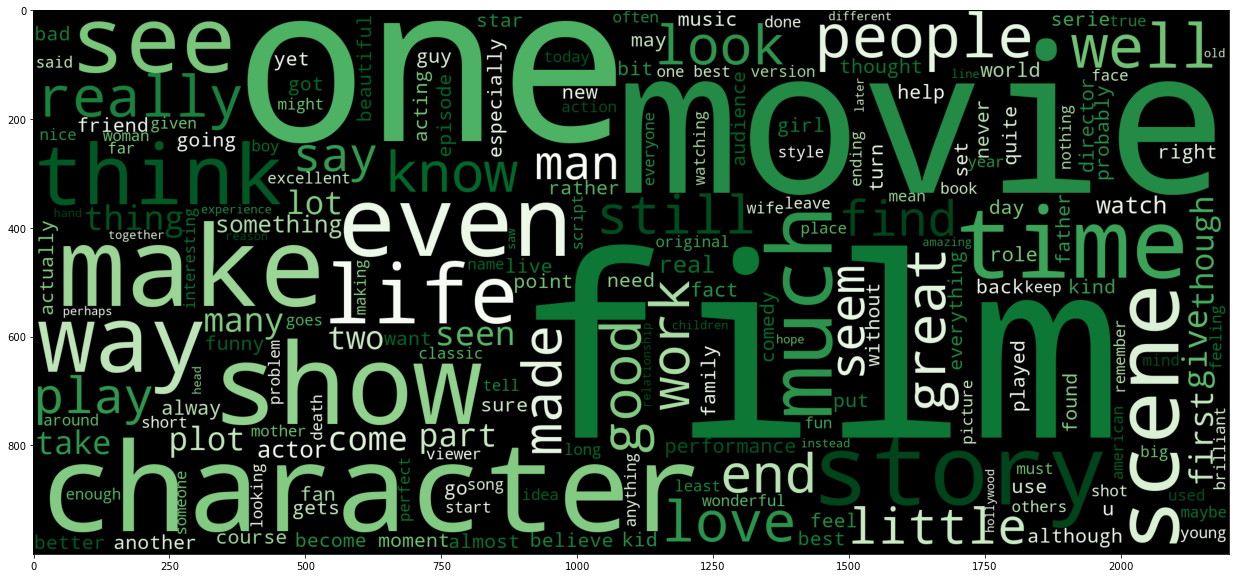

In [15]:
# Define function for generating word clouds
def draw_wordcloud(tokens, colormap):
    
    # Instantiate plot
    plt.figure(figsize = (22,10))
    
    # Instantiate wordcloud
    wc = WordCloud(max_words = 200, 
                   width = 2200, height = 1000, 
                   colormap=colormap).generate(" ".join(tokens_pos))
    
    #Show wordcloud
    plt.imshow(wc)

# Plot word cloud with positive tokens
draw_wordcloud(tokens_pos, "Greens")

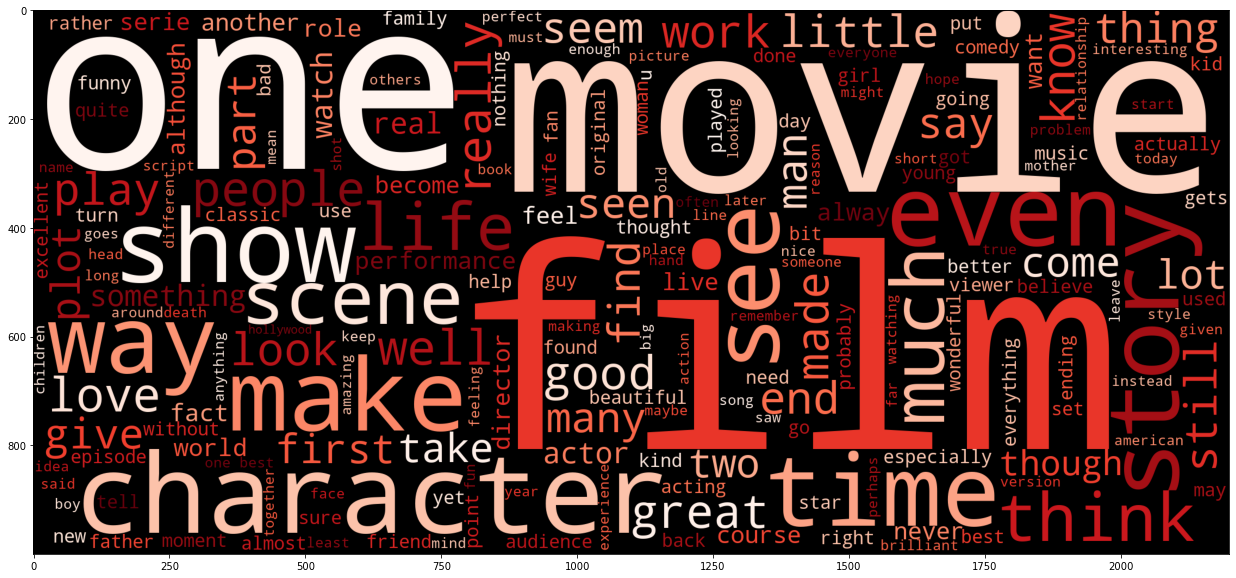

In [16]:
# Plot word cloud with negative tokens
draw_wordcloud(tokens_neg, "Reds")

Aside from the color palettes, the results match what we found in our frequency distributions.

## Ngrams

Ngrams are another useful tool for exploratory analysis.  Instead of singular tokens, ngrams demonstrate the frequency of specific phrases.  Let's take at ngrams with one, two, three, and four words with our positive and negative dataframes.

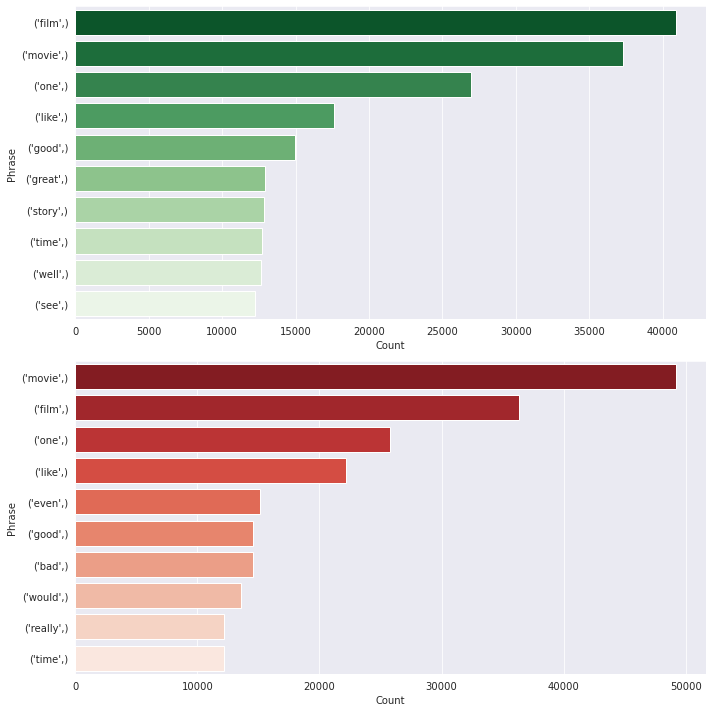

In [17]:
# Define function for plotting horizontal bar charts based on ngrams
def plot_ngram(i, tokens_pos=tokens_pos, tokens_neg=tokens_neg):
    
    # Setting up ngrams depending on our specified value for 'i'
    n_gram_pos = (pd.Series(nltk.ngrams(tokens_pos, i)).value_counts())[:10]
    n_gram_neg = (pd.Series(nltk.ngrams(tokens_neg, i)).value_counts())[:10]
    
    # Creating p/n dataframes
    n_gram_df_pos = pd.DataFrame(n_gram_pos)
    n_gram_df_neg = pd.DataFrame(n_gram_neg)
    
    # Resetting index for labeling on plots
    n_gram_df_pos = n_gram_df_pos.reset_index()
    n_gram_df_neg = n_gram_df_neg.reset_index()
    
    # Renaming plots
    n_gram_df_pos = n_gram_df_pos.rename(columns={'index': 'Phrase', 0: 'Count'})
    n_gram_df_neg = n_gram_df_neg.rename(columns={'index': 'Phrase', 0: 'Count'})
    
    # Setting seaborn grid style to 'darkgrid'
    with sns.axes_style('darkgrid'):
        
        # Setting up two figures to stack on top of each other
        fig = plt.figure(figsize = (10,10))
        ax1 = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)
        
        # Assigning each barplot to positive and negative ngram sets
        sns.barplot(ax=ax1, x='Count',y='Phrase', data=n_gram_df_pos, palette='Greens_r')
        sns.barplot(ax=ax2, x='Count',y='Phrase', data=n_gram_df_neg, palette='Reds_r')
    
    # Return plot with tight layout
    plt.tight_layout()

# Plot one word ngrams
plot_ngram(1)

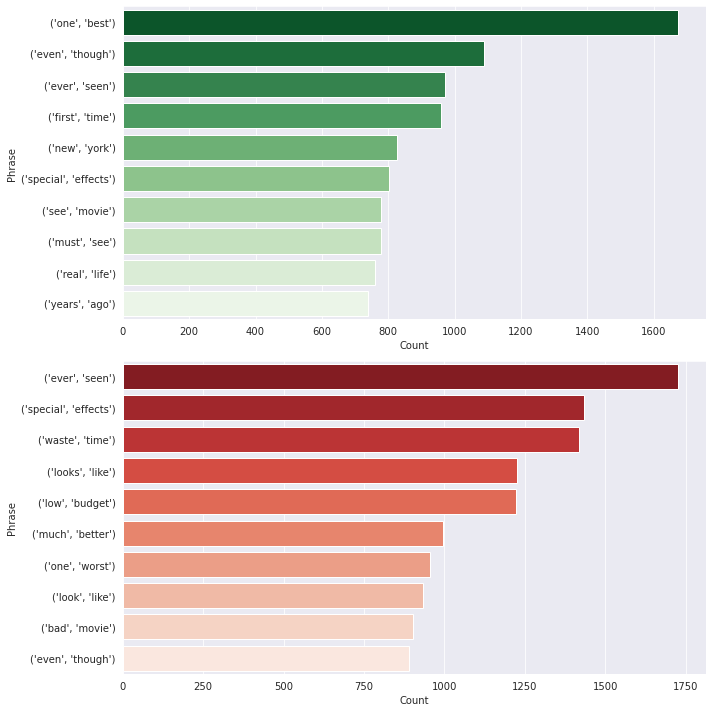

In [18]:
# Plot two word ngrams
plot_ngram(2)

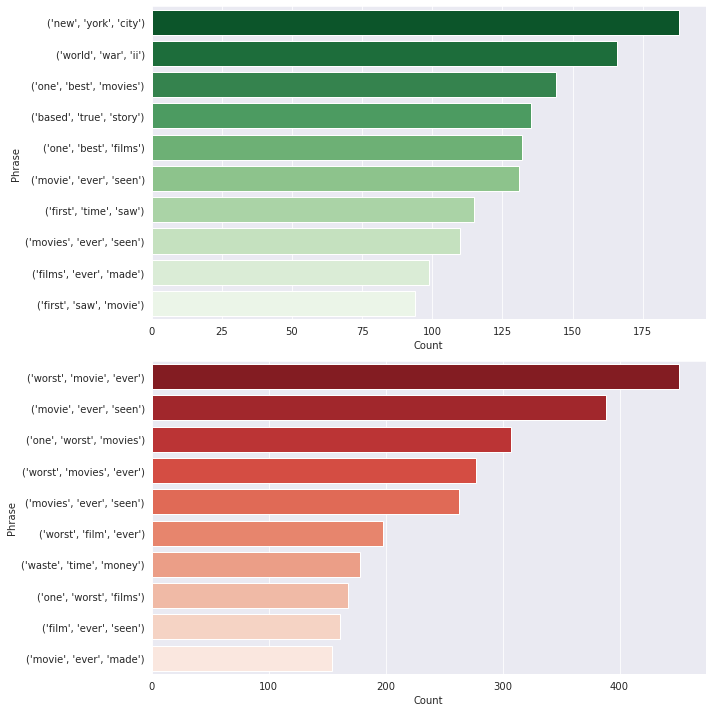

In [19]:
# Plot three word ngrams
plot_ngram(3)

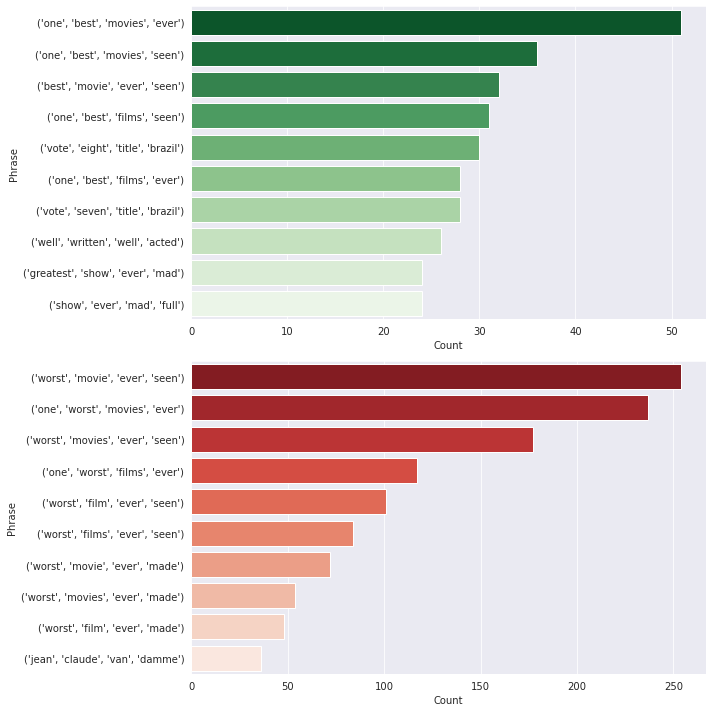

In [20]:
# # Plot four word ngrams
plot_ngram(4)

Finally, the differences in positive and negative tokens are becoming more evident.  

Ngrams(3) shows us more interesting information than Ngrams(1) and Ngrams(2).  New York City appears as the top most frequent among trigrams, as does World War II.  The rest are superlative - "one best films," "movie ever seen," "films ever made."  

The negative trigrams are more superlative and don't include things we wouldn't normally expect like New York City and World War II.  This might lead us to consider whether or not movies based in New York City are more well reviewed, and if World War II movies also receive a similar boost.  Perhaps fans of movies portraying NYC and WWII are more likely to write positive reviews.

Adorably, Jean Claude Van Damme appears frequently in the negative ngram(4) plot.

## Mutual Information Scores

Pairwise mutual information scores are also worth a quick look.  This will give us a measure of association between two tokens.

In [21]:
# Instantiating NLTK's Bigramn Association Measures
bigram_measures = nltk.collocations.BigramAssocMeasures()

# Instantiating Bigram Collocation Finder
tokens_pmi_finder = BigramCollocationFinder.from_words(tokens)

# Applying a frequency filter - bigram must appear at least 500 times
tokens_pmi_finder.apply_freq_filter(500)

# Scoring the tokens based on our bigram measures
tokens_pmi_scored = tokens_pmi_finder.score_ngrams(bigram_measures.pmi)

# Show scores
tokens_pmi_scored

[(('sci', 'fi'), 12.014985625405476),
 (('th', 'century'), 10.941059050317797),
 (('production', 'values'), 9.938295540111962),
 (('low', 'budget'), 9.617255903440476),
 (('special', 'effects'), 9.442463595883456),
 (('new', 'york'), 9.437849429863778),
 (('high', 'school'), 8.821587200156959),
 (('highly', 'recommend'), 8.735826357910884),
 (('years', 'ago'), 8.705289579685402),
 (('black', 'white'), 8.56233814091226),
 (('supporting', 'cast'), 8.237654151722769),
 (('half', 'hour'), 8.223432319941598),
 (('year', 'old'), 7.977964402482492),
 (('character', 'development'), 7.918511003378143),
 (('read', 'book'), 7.718890452656954),
 (('takes', 'place'), 7.602421569135796),
 (('writer', 'director'), 7.505539139359406),
 (('worth', 'seeing'), 7.297108484893386),
 (('camera', 'work'), 7.150295316173729),
 (('years', 'later'), 7.116356389401524),
 (('anything', 'else'), 7.106818491593305),
 (('waste', 'time'), 7.003592480433181),
 (('worth', 'watching'), 6.904774014077198),
 (('main', 'ch

All of the pairs make sense within the context of our dataset.  While many didn't appear in the list of top ngrams, it isn't surprising to see phrases like "sci fi," "production values," and "low budget" as having a high likelihood of appearing alongside one another.  

# Modeling

Now that we have a better understanding of our dataset, we'll move on to our machine learning models.  For the models, we'll be using two different vectorizers - Count Vectorization and TF-IDF Vectorization.



## Count Vectorizer

The Count Vectorizer will convert all of our tokens into frequency representations, similar to what we did with our frequency distribution.  While it's a good start, count vectorization has a couple of flaws:

- It doesn't distinguish between more and less important tokens.
- It only will consider the most frequent terms as the most statistically important.  Words like "movie" and "film" appear frequently for both positive and negative reviews, and these will both be considered statistically important for both classifiers.

Below, we will set up our vectorizer using our original review set, since the vectorizer has the capability of tokenizing for us.  We will also separately specify our stop words list.  Creating our vectorizers this way will allow us flexibility if we wish to use a different tokenizer or stop words list in another iteration of this project.

In [22]:
# Instantiating count vectorizer using my_tokenizer and stop_words_list
cv = CountVectorizer(strip_accents='unicode', 
                     tokenizer=my_tokenizer, 
                     stop_words=stop_words_list
                    )

# Assigning X and y for train test split
X = df['review']
y = df['sentiment']

# Apply train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=8)

# Fit both x train and test for CV
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

#Check X_train_cv
X_train_cv

<34707x93802 sparse matrix of type '<class 'numpy.int64'>'
	with 3392481 stored elements in Compressed Sparse Row format>

## TF-IDF Vectorizer

The Term Frequency - Inverse Document Frequency (TF-IDF) Vectorizer makes up for some of the shortcomings in the Count Vectorizer by penalizing words that are too abundant or too rare.  In other words, if a token is found frequently in review A but not frequently in review B, then that token will be considered more significant as it might provide additional insight to the rest of the corpus.

In [23]:
# Instantiating TF-IDF vectorizer using my_tokenizer and stop_words_list
tfidf = TfidfVectorizer(strip_accents='unicode', 
                        tokenizer=my_tokenizer, 
                        stop_words=stop_words_list
                       )

# Fit both x train and test for TF-IDF
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Check X_train_tfidf
X_train_tfidf

<34707x93802 sparse matrix of type '<class 'numpy.float64'>'
	with 3392481 stored elements in Compressed Sparse Row format>

## Model Evaluation Function

Before running our models, we'll create our model evaluation function.  This will be used to compare the performances of the various machine learning models.

In [24]:
def evaluate_model(model, X_train, X_test, y_train=y_train, 
                   y_test=y_test, cmap='Greens', normalize=None,
                   classes=None,figsize=(10,4)):
    
    # Print model accuracy
    print(f'Training Accuracy: {model.score(X_train,y_train):.2%}')
    print(f'Test Accuracy: {model.score(X_test,y_test):.2%}')
    print('')
    
    # Print classification report
    y_test_predict = model.predict(X_test)
    print(metrics.classification_report(y_test, y_test_predict,
                                        target_names=classes))
    
    # Plot confusion matrix
    fig,ax = plt.subplots(ncols=2,figsize=figsize)
    metrics.plot_confusion_matrix(model, X_test,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                  ax=ax[0])
    
    #Plot ROC curves
    with sns.axes_style("darkgrid"):
        curve = metrics.plot_roc_curve(model,X_train,y_train,ax=ax[1])
        curve2 = metrics.plot_roc_curve(model,X_test,y_test,ax=ax[1])
        curve.ax_.grid()
        curve.ax_.plot([0,1],[0,1],ls=':')
        fig.tight_layout()
        plt.show()

## Logistic Regression

We'll start off by running one of the more basic machine learning models, logistic regression. We will perform this both on our CV and TF-IDF vectorizers.

### Logistic Regression CV

In [25]:
# Logistic Regression with Count Vectoriser
cv_log = LogisticRegression(random_state=8, n_jobs=-1)

# Fit X_train_cv
cv_log.fit(X_train_cv, y_train)

LogisticRegression(n_jobs=-1, random_state=8)

Training Accuracy: 99.74%
Test Accuracy: 88.18%

              precision    recall  f1-score   support

    negative       0.88      0.88      0.88      7321
    positive       0.88      0.88      0.88      7554

    accuracy                           0.88     14875
   macro avg       0.88      0.88      0.88     14875
weighted avg       0.88      0.88      0.88     14875



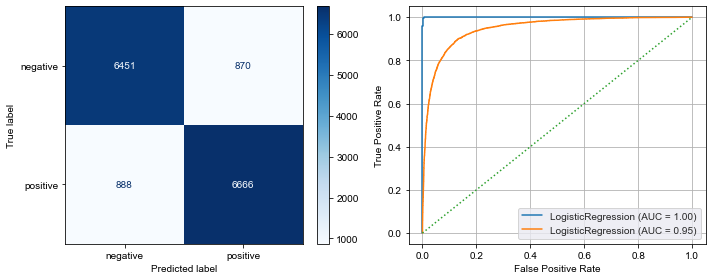

In [26]:
# Evaluate model performance
evaluate_model(cv_log, X_train_cv, X_test_cv, cmap='Blues')

### Logistic Regression TF-IDF

In [27]:
# Logistic Regression with TF-IDF Vectoriser
tfidf_log = LogisticRegression(penalty='l2',C=100)
tfidf_log.fit(X_train_tfidf, y_train)

LogisticRegression(C=100)

Training Accuracy: 99.99%
Test Accuracy: 88.71%

              precision    recall  f1-score   support

    negative       0.88      0.89      0.89      7321
    positive       0.89      0.89      0.89      7554

    accuracy                           0.89     14875
   macro avg       0.89      0.89      0.89     14875
weighted avg       0.89      0.89      0.89     14875



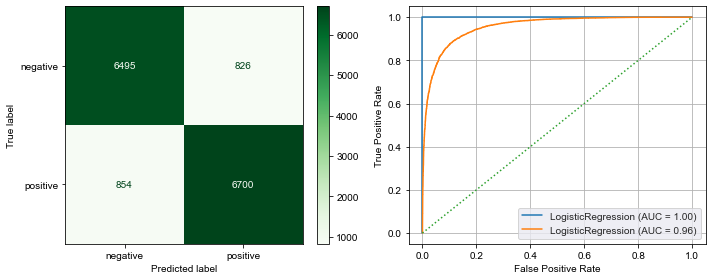

In [28]:
evaluate_model(tfidf_log, X_train_tfidf, X_test_tfidf, cmap='Greens')

Accuracy is surprisingly high for our first modeling attempt.  Both CV and TF-IDF score above 88% accuracy.  

### Coefficient Analysis

Given the strong performance of the logistic regression model using TF-IDF, it is worth taking a look at the coefficients of the model.  In this case, the coefficients will be the individual tokens in our corpus.  We will be able to tell which words influenced the model in determining whether a review is positive or negative.

In [31]:
# Create list of feature names
feature_names = tfidf.get_feature_names()

# Create empty dataframe to store coefficients
df_coef = pd.DataFrame()

# Populate columns with feature names and corresponding coefficents
df_coef['features'] = feature_names
df_coef['coefficients'] = tfidf_log.coef_.flatten()

# Sort coefficients by descending values
df_coef = df_coef.sort_values(by='coefficients', ascending=False)

# Create another dataframe with only the top 10 and bottom 10 coefficients
df_top_bottom = df_coef.iloc[np.r_[0:10, -10:0]]

# View top 10 and bottom 10 coefficients
df_top_bottom

,features,coefficients
27604,excellent,18.642435
67983,refreshing,16.945521
34781,great,16.733728
61686,perfect,15.880633
10249,brilliant,15.517564
84059,today,15.169792
80181,subtle,14.934248
80600,superb,14.888274
32831,gem,14.850102
7567,best,14.356892


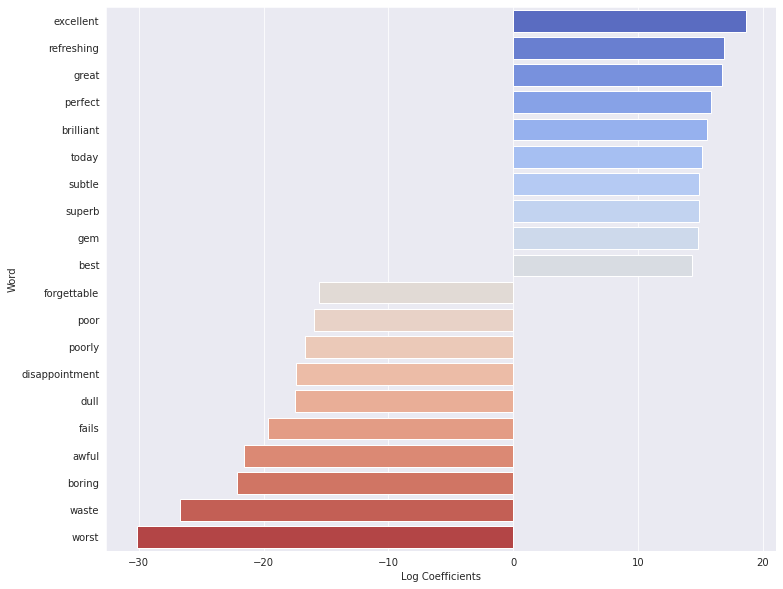

In [32]:
# Define plot coefficient function
def plot_coefficients(df, filename='image'):    

    # Create coefficients plot
    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(12, 10))
        ax = sns.barplot(data=df, x='coefficients', y='features', palette='coolwarm')
        ax.set(xlabel='Log Coefficients', ylabel='Word')

# View coefficient plot
plot_coefficients(df_top_bottom)

Based on this plot of the top 10 influential words in the positive and negative direction, it looks like the model latched onto polar descriptive adjectives that we would normally associate with positive or negative sentiment.  

## Random Forest

A different type of machine learning model we can try is random forests.  We'll attempt this model with both the count and TF-IDF vectorizer.

### Random Forest CV

In [33]:
# Initiate a random forest model for CV
rf_cv = RandomForestClassifier(random_state=8, n_jobs=-1)

# Fit to X_train_cv and y_train
rf_cv.fit(X_train_cv, y_train)

RandomForestClassifier(n_jobs=-1, random_state=8)

Training Accuracy: 100.00%
Test Accuracy: 85.82%

              precision    recall  f1-score   support

    negative       0.85      0.87      0.86      7321
    positive       0.87      0.85      0.86      7554

    accuracy                           0.86     14875
   macro avg       0.86      0.86      0.86     14875
weighted avg       0.86      0.86      0.86     14875



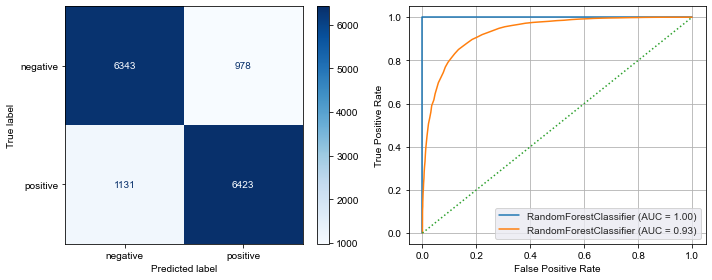

In [34]:
evaluate_model(rf_cv, X_train_cv, X_test_cv, cmap='Blues')

### Random Forest TF-IDF

In [35]:
# Initiate a random forest model for TF-IDF
rf_tfidf = RandomForestClassifier(random_state=8, n_jobs=-1)

# Fit to X_train for TF-IDF
rf_tfidf.fit(X_train_tfidf, y_train)

RandomForestClassifier(n_jobs=-1, random_state=8)

Training Accuracy: 100.00%
Test Accuracy: 85.33%

              precision    recall  f1-score   support

    negative       0.84      0.87      0.85      7321
    positive       0.87      0.84      0.85      7554

    accuracy                           0.85     14875
   macro avg       0.85      0.85      0.85     14875
weighted avg       0.85      0.85      0.85     14875



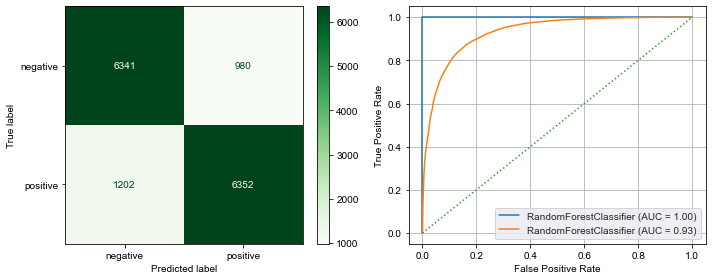

In [36]:
evaluate_model(rf_tfidf, X_train_tfidf, X_test_tfidf, cmap='Greens')

The random forest models were less accurate than our logistic regression model with TF-IDF.

## XGBoost

Finally, we'll try XGBoost, which is a more advanced machine learning model.  Hopefully this will give us a performance boost of some kind.

### XGBoost CV

In [37]:
# Instantiate XGB classifier for CV
xgb_cv = XGBClassifier(random_state=8, n_jobs=-1)

# Fit to X_train_cv and y_train
xgb_cv.fit(X_train_cv, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=8,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Training Accuracy: 92.43%
Test Accuracy: 85.51%

              precision    recall  f1-score   support

    negative       0.87      0.84      0.85      7321
    positive       0.85      0.87      0.86      7554

    accuracy                           0.86     14875
   macro avg       0.86      0.85      0.85     14875
weighted avg       0.86      0.86      0.85     14875



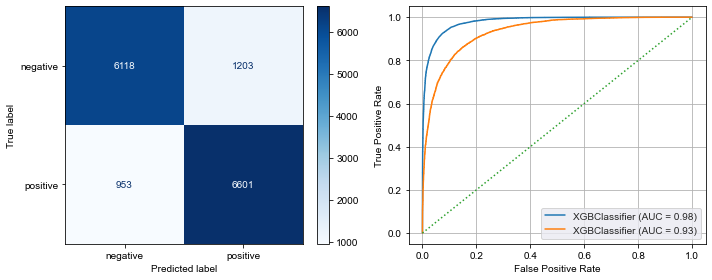

In [38]:
evaluate_model(xgb_cv, X_train_cv, X_test_cv, cmap='Blues')

### XGBoost TF-IDF

In [39]:
# Instantiate XGB model for TF-IDF
xgb_tfidf = XGBClassifier(random_state=8, n_jobs=-1)

# Fit to X_train_tfidf
xgb_tfidf.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=8,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Training Accuracy: 93.37%
Test Accuracy: 85.36%

              precision    recall  f1-score   support

    negative       0.86      0.83      0.85      7321
    positive       0.84      0.87      0.86      7554

    accuracy                           0.85     14875
   macro avg       0.85      0.85      0.85     14875
weighted avg       0.85      0.85      0.85     14875



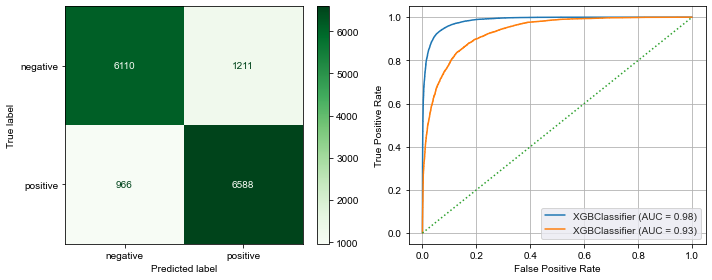

In [40]:
evaluate_model(xgb_tfidf, X_train_tfidf, X_test_tfidf, cmap='Greens')

Similar to the random forest model, XGBoost did not provide us with any additional accuracy.  It looks like logistic regression will be our best bet for now.

## Logistic Regression with Grid Search

As a last step, we'll expand upon our logistic regression model with TF-IDF by performing a grid search.  This process will iterate through multiple parameters and return a logistic regression model that optimizes for accuracy.  

In [41]:
# Initiate new model and perform grid search
tfidf_log_gs = LogisticRegression()

# If run = True, code will perform full grid search
# If run = False, code will use previously calculated best parameters
run = False

if run == True:

# Define lists of parameters to compare
    params = {'C':[0.01,0.1,1,10,100],
            'penalty':['l1','l2','elastic_net'],
            'solver':["liblinear", "newton-cg", "lbfgs", "sag","saga"]
             }
    
else:
    
    # Previously calculated best parameters
    params = {'C':[10],
            'penalty':['l2'],
            'solver':["newton-cg"]
             }

# Run the grid search with a focus on accuracy
log_grid_search = GridSearchCV(tfidf_log_gs,params,scoring='accuracy',
                              verbose=100,
                              n_jobs=-1)

# Fit grid search to training data and display best parameters
log_grid_search.fit(X_train_tfidf, y_train)

# Print best parameters
log_grid_search.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.4s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.7s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.7s finished


{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}

Training Accuracy: 98.82%
Test Accuracy: 89.51%

              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      7321
    positive       0.90      0.90      0.90      7554

    accuracy                           0.90     14875
   macro avg       0.90      0.90      0.90     14875
weighted avg       0.90      0.90      0.90     14875



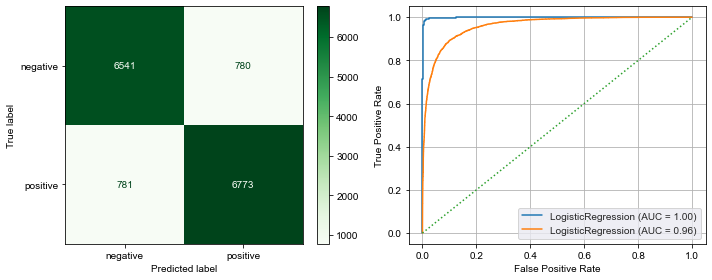

In [42]:
evaluate_model(log_grid_search.best_estimator_, X_train_tfidf, X_test_tfidf,
              cmap='Greens')

Using grid search, we were able to eek out just a bit more performance.  Our baseline logistic regression model with TF-IDF scored 88.73%, and our grid search model improved accuracy to 89.51%.  

# Interpretation

Most of our models performed reasonably well.  Perhaps the method of using decision trees in Random Forest and XGBoost isn't as useful when working with a dataset with this many features.  All models suffered from overfitting, and it might be a good step in the future to examine the causes of this more closely.

## Best Model - Logistic Regression with Grid Search using TF-IDF Vectorizer

Despite our implementation of more complex machine learning models, the tried and true logistic regression model with grid search was the best performer at 89.51% accuracy.  

Training Accuracy: 98.82%
Test Accuracy: 89.51%

              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      7321
    positive       0.90      0.90      0.90      7554

    accuracy                           0.90     14875
   macro avg       0.90      0.90      0.90     14875
weighted avg       0.90      0.90      0.90     14875



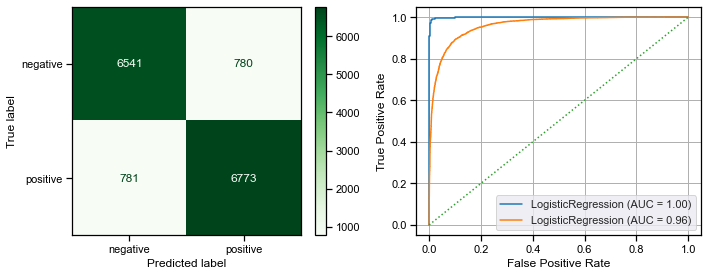

In [43]:
evaluate_model(log_grid_search.best_estimator_, X_train_tfidf, X_test_tfidf,
              cmap='Greens')

# Conclusions and Recommendations

The goal of this project was to determine whether or not it would be possible to distinguish between positive and negative reviews using only the content of the review and the 'positive' or 'negative' classifiers.  We accomplished this with reasonable success with grid search logistic regression and the TF-IDF vectorizer scoring 89.51% accuracy.  

We also learned from our EDA and visual exploration of coefficients that the machine learning models are latching onto strong positive and strong negative adjectives to make its decisions.  This does not fall out of line with what we might expect.  

Using this model, we might be able to calculate a new score for movies on IMDB that more closely reflects what is found on the Rotten Tomatoes Critic Score.  A metric like this could help avoid issues where IMDB users felt very similarly about a movie, but gave it different numerical scores based on their own interpretation of the 1-10 scale.  

The benefits of this new type of score might not be immediately tangible, but running this model and scoring all movies in IMDB's database might return an alternate top 250 movies list that would at the very least be interesting to users.

## Next Steps

We aren't entirely sure how each of the 50,000 reviews were deemed 'positive' or 'negative.'  According to the data source on Kaggle, the reviews were "highly polar," but we don't understand how this informed the data collection process.  

It might be worthwhile to pull 50,000 reviews from IMDB in a bucket of scores from 1-3, 4-7, and 8-10.  This would allow us to perform a multiclass sentiment analysis and see if we can determine whether reviews are positive, negative, or neutral.  While computationally expensive and possibly a fool's errand, the same logic could be applied to bucketing every 1-10 score in buckets of 1, 2, 3, etc.

Also, while we explored three models for this project, there are many more machine learning models that we could have attempted, such as support vector machines, k nearest neighbors, and a variety of deep learning / neural network models.  Exploring more models might lead to a higher accuracy and could inform future experimentation.